In [266]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from matplotlib.pyplot import figure
from pathlib import Path
from sklearn.metrics import plot_confusion_matrix
import optuna
from optuna import create_study
from optuna.samplers import TPESampler
from optuna.integration import XGBoostPruningCallback

import json

In [2]:
data_path = Path('../anes-data')
figures_path = Path('../figures')

In [268]:
config = {}

In [3]:
intubs = pd.read_csv(data_path / 'intubs.csv')
ptx_info_dose = pd.read_csv(data_path / 'ptx-info-dose.csv')
outcome_vitals = pd.read_csv(data_path / 'outcome_vitals.csv')
ptx_info = pd.read_csv(data_path / 'ptx-info.csv')
avg_vitals = pd.read_csv(data_path / 'avg_vitals.csv')
pt_drug_x = pd.read_csv(data_path / 'pt_drug_x.csv')
intubes_pt_info = pd.read_csv(data_path / 'intubes_pt_info.csv')

In [4]:
outcome_vitals = outcome_vitals.drop(['sbp_ni', 'dbp_ni', 'mbp_ni'], axis=1)
avg_vitals = avg_vitals.drop(['avg_sbp_ni', 'avg_dbp_ni', 'avg_mbp_ni'], axis=1)

In [5]:
patient_data = (intubes_pt_info
        .drop('subject_id', axis=1)
        .set_index('stay_id')
        .join(avg_vitals.drop('subject_id', axis=1)
        .set_index('stay_id'), how='inner')
        .reset_index()
        .drop(['hadm_id'], axis=1)
        .set_index('stay_id')
        .join(avg_vitals[['subject_id', 'stay_id']]
        .set_index('stay_id'))
        .join(intubs.set_index('stay_id')['patientweight'])
        .drop_duplicates())

In [272]:
drugs = ["Furosemide",
"Metoprolol Tartrate",
"Propofol",
"Fentanyl Citrate",
"Lorazepam",
"HYDROmorphone (Dilaudid)",
"Haloperidol",
"Nitroglycerin",
"Midazolam",
"PHENYLEPHrine",
"NORepinephrine"]

config['drugs'] = drugs

with open('../config.json', 'w') as f:
    f.write(json.dumps(config))

In [7]:
drugs = set(pt_drug_x.medication) & set(drugs)
dosage = ptx_info_dose[ptx_info_dose.medication.isin(drugs)][['subject_id', 'stay_id', 'medication', 'dose_given', 'dose_given_unit']].dropna()

In [8]:
len(dosage), len(patient_data)

(2990, 7768)

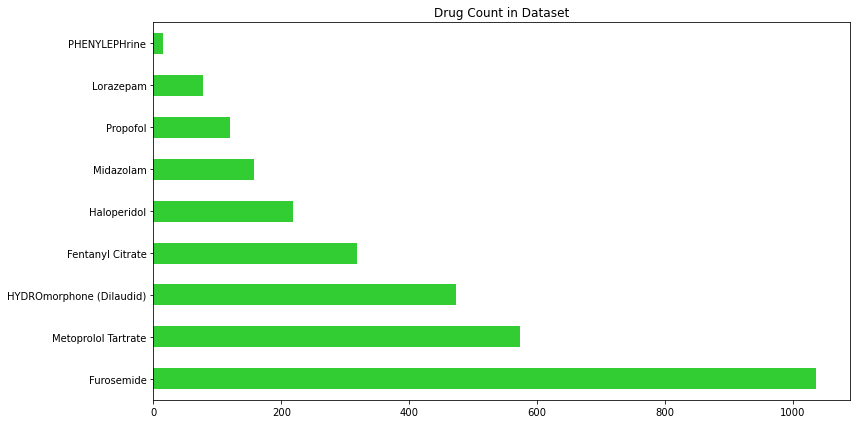

In [94]:
dosage.medication.value_counts().plot(kind='barh', color='limegreen', figsize=(12, 6))
plt.title('Drug Count in Dataset')
plt.tight_layout()
plt.savefig(figures_path / 'drugs.png', dpi=120)
plt.show()

In [9]:
encoded_ptx_drugs = pd.get_dummies(pt_drug_x.set_index('stay_id').medication)[drugs].reset_index().groupby('stay_id').sum()

In [10]:
patient_data = patient_data.join(encoded_ptx_drugs, how='left').drop_duplicates().drop(['avg_sbp', 'avg_dbp'], axis=1)

In [11]:
set(patient_data.subject_id).__len__()

7066

/ihome/hosmanbeyoglu/kor11/.local/lib/python3.8/site-packages/missingno/missingno.py:60: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


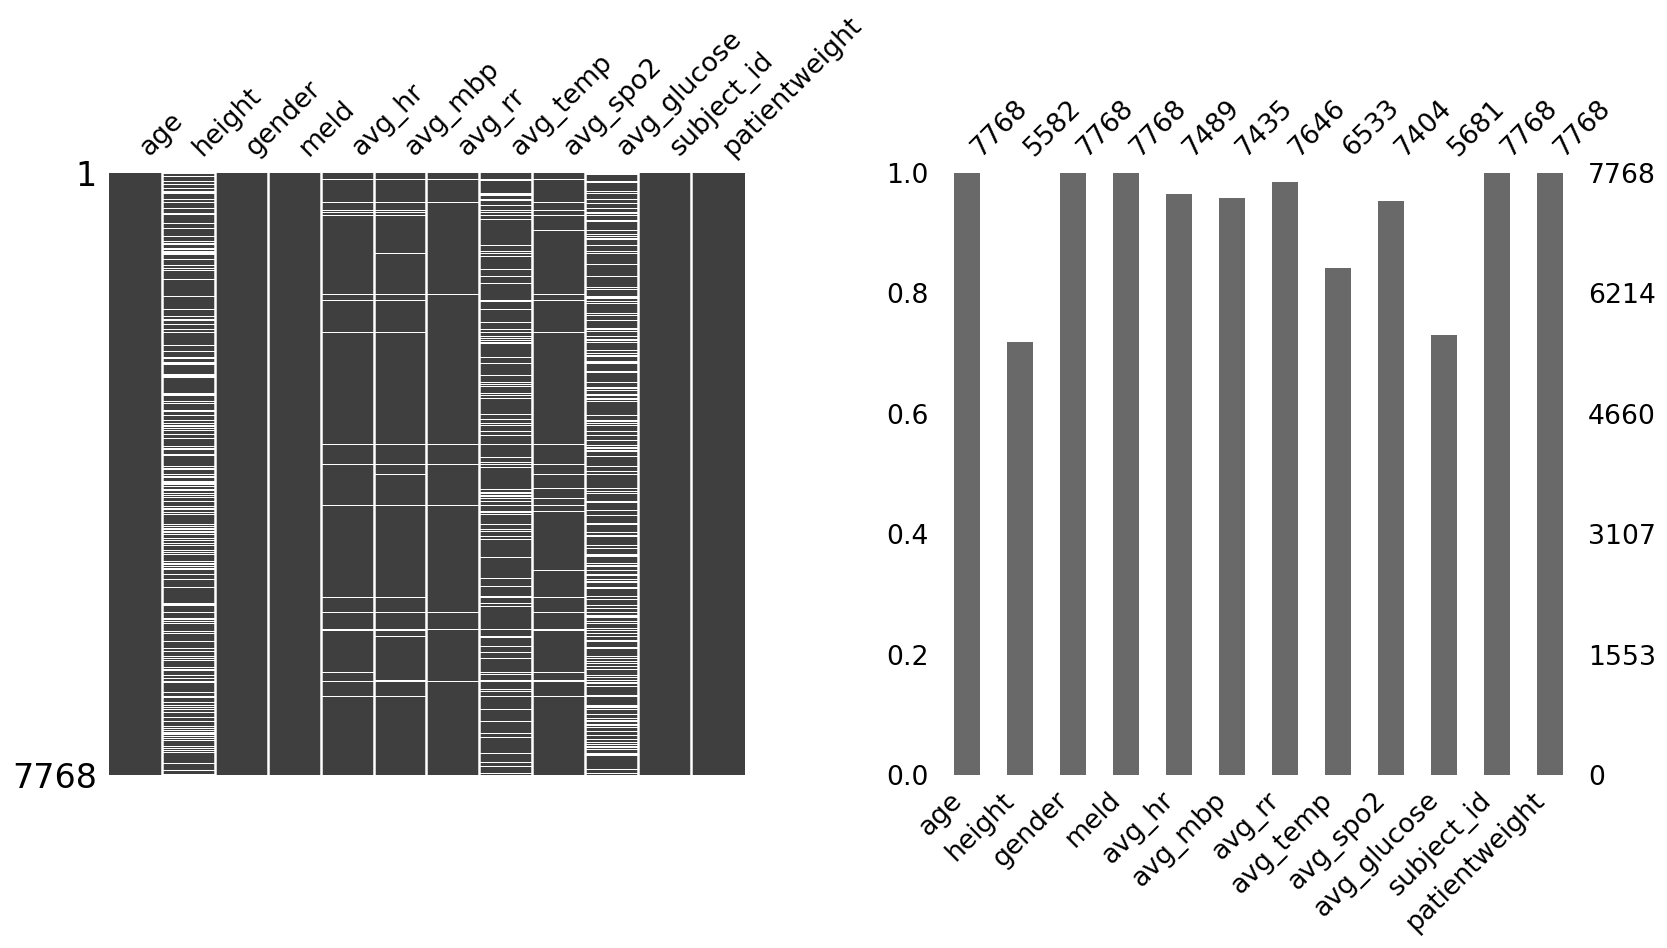

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 8), dpi=120)
msno.matrix(patient_data.drop(drugs, axis=1), ax=axes[0])
msno.bar(patient_data.drop(drugs, axis=1), ax=axes[1])
plt.tight_layout()
plt.savefig(figures_path / 'missing_data.png', dpi=120)
plt.show()

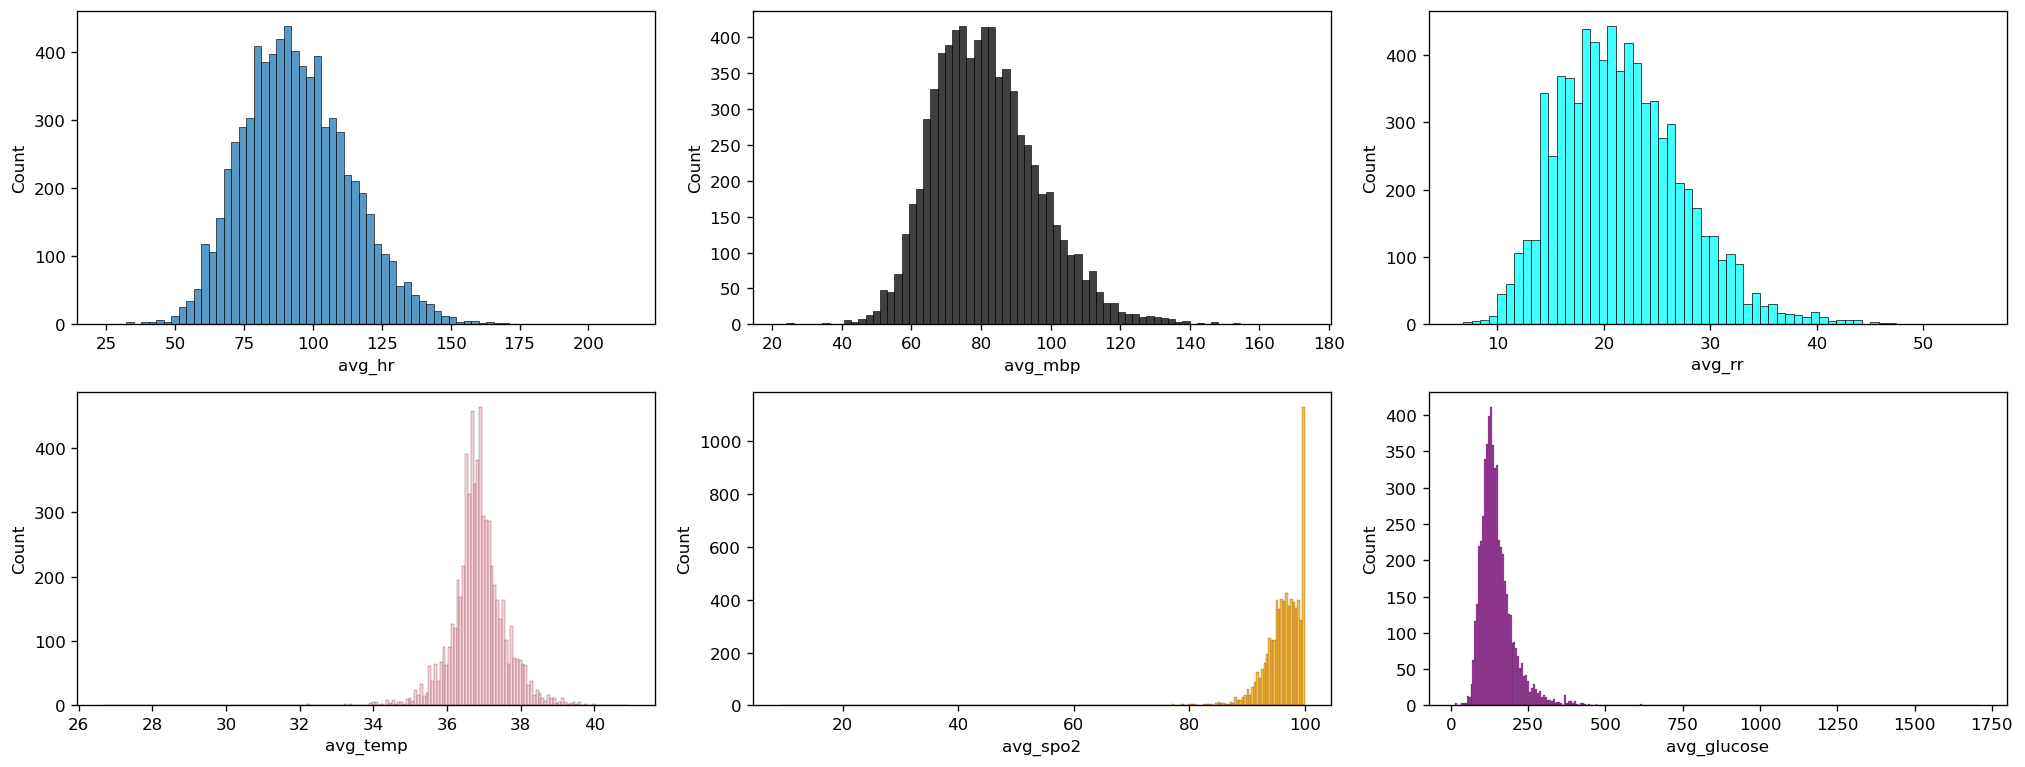

In [53]:
fig, axes = plt.subplots(2, 3, figsize=(17, 6.5), dpi=120)

sns.histplot(data=patient_data, x='avg_hr', ax=axes[0][0])
sns.histplot(data=patient_data, x='avg_mbp', ax=axes[0][1], color='black')
sns.histplot(data=patient_data, x='avg_rr', ax=axes[0][2], color='cyan')
sns.histplot(data=patient_data, x='avg_temp', ax=axes[1][0], color='pink')
sns.histplot(data=patient_data, x='avg_spo2', ax=axes[1][1], color='orange')
sns.histplot(data=patient_data, x='avg_glucose', ax=axes[1][2], color='purple')
plt.tight_layout()
plt.savefig(figures_path / 'vitals_distribution.png', dpi=120)
plt.show()

<Figure size 360x360 with 0 Axes>

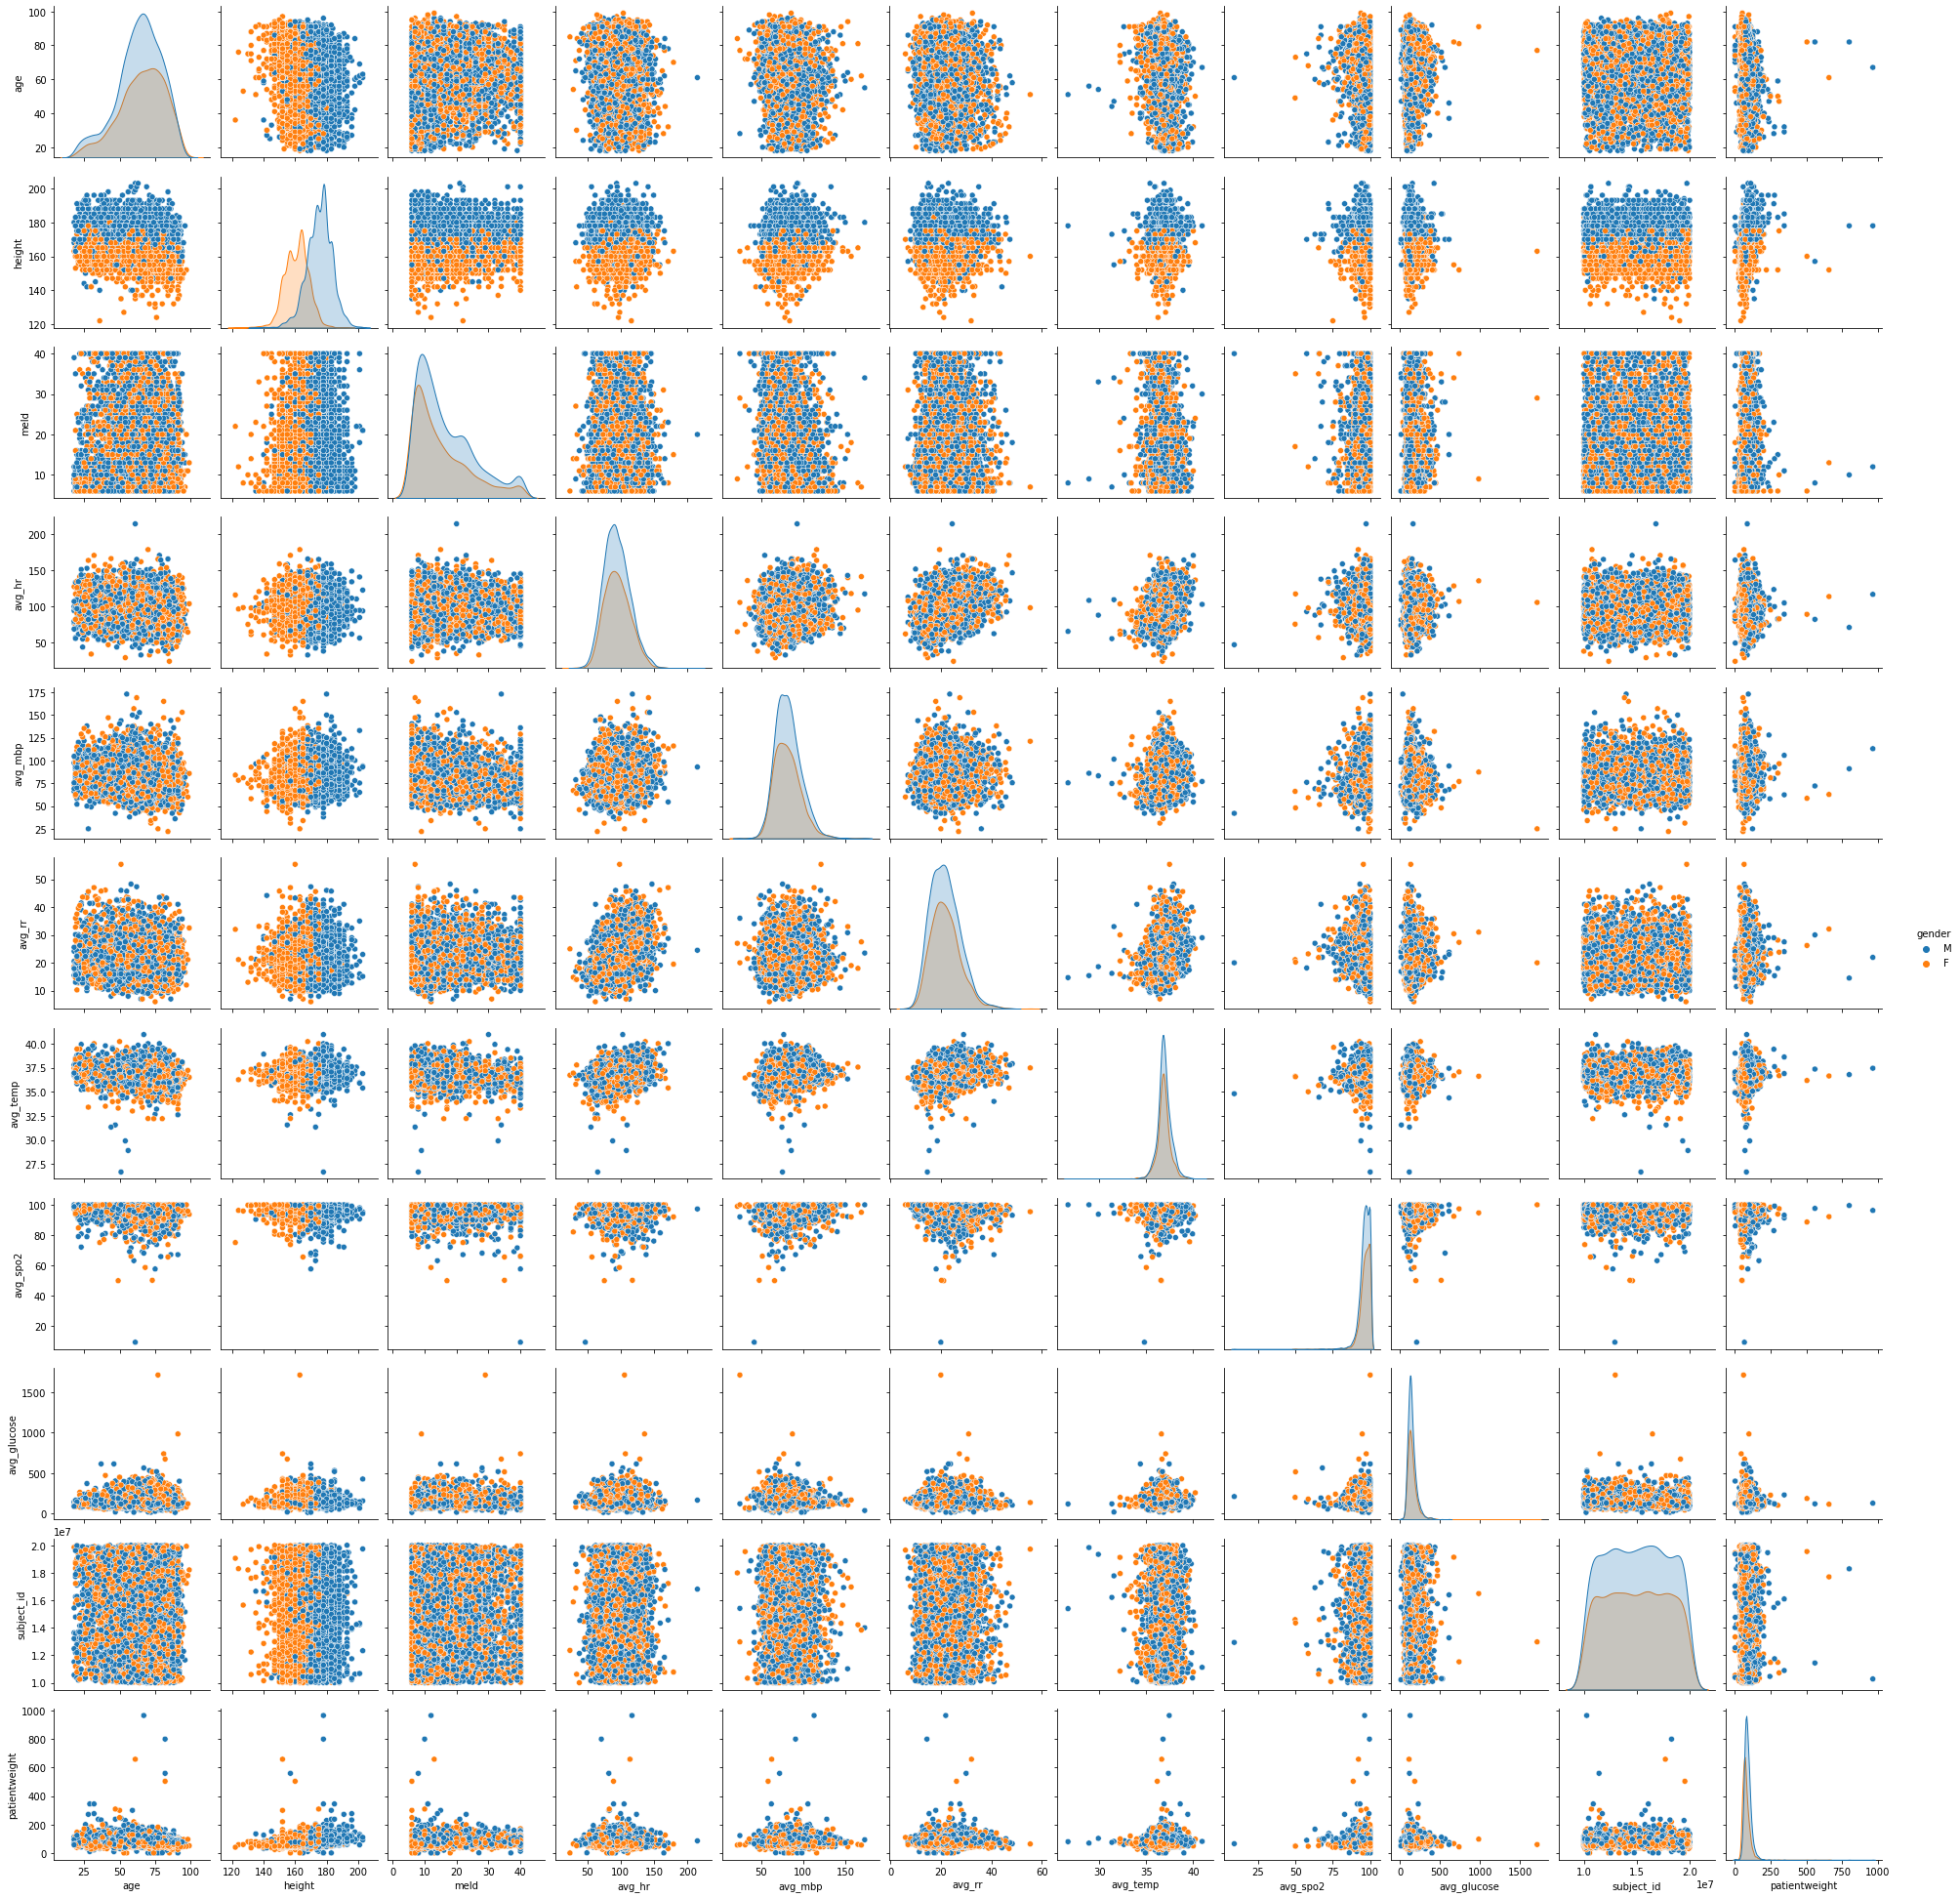

In [71]:
figure(figsize=(3, 3), dpi=120)
sns.pairplot(patient_data.drop(drugs, axis=1), hue='gender')
plt.savefig(figures_path / 'pairplot.png', dpi=120)
plt.show()

In [12]:
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error

In [13]:
# patient_data = patient_data.join(encoded_ptx_drugs, how='left').drop_duplicates().drop(['avg_sbp', 'avg_dbp'], axis=1).reset_index()

In [14]:
drugs = list(drugs)

In [15]:
patient_data[drugs] = patient_data[drugs].fillna(value=0)

In [16]:
def get_event(avg_hr, avg_mbp, avg_rr, avg_spo2, avg_glucose):
    hr = False
    rr = False
    spo2 = False
    gluc = False
    
    if avg_hr < 60 or avg_hr > 110:
        hr = True
    if avg_rr < 10:
        rr = True
    if avg_spo2 < 85:
        spo2 = True
#     if avg_glucose < 100:
#         gluc = True
        
    if any([hr, rr, spo2, gluc]): return 1
    else: return 0

In [17]:
dosage['encoded_dose'] = dosage.apply(lambda x: f'{x.medication}_{x.dose_given}_{x.dose_given_unit}', axis=1)

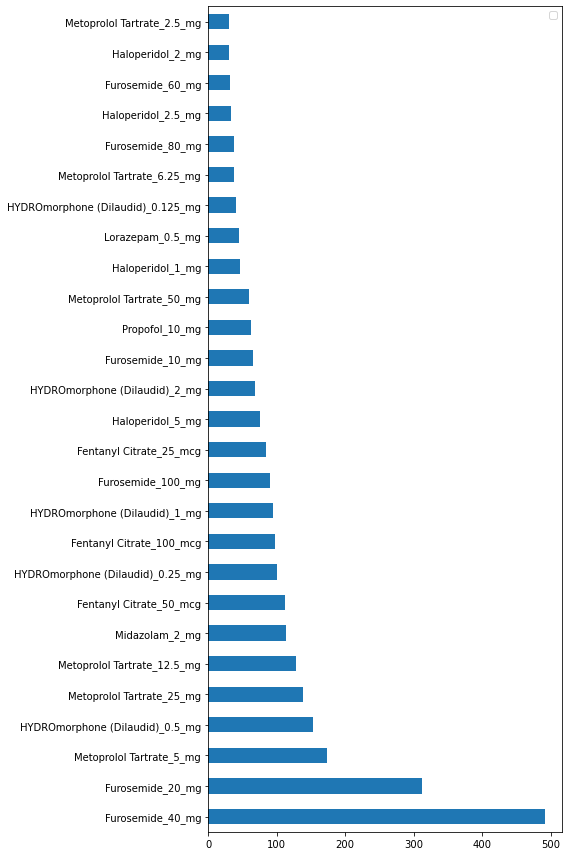

In [63]:
pd.DataFrame(dosage['encoded_dose'].value_counts()).loc[[k for k, v in dict(dosage['encoded_dose'].value_counts(normalize=True) >= 0.01).items() if v]].plot(kind='barh', figsize=(8, 12))
plt.legend('')
plt.tight_layout()
plt.savefig(figures_path / 'common_dose_dosages.png', dpi=120)
plt.show()

In [18]:
patient_data = patient_data.join(dosage.set_index('stay_id').drop('subject_id', axis=1)['encoded_dose']).drop_duplicates()
patient_data = patient_data.join(pd.get_dummies(patient_data.gender)).drop('gender', axis=1)

In [19]:
patient_data = patient_data.join(pd.get_dummies(patient_data['encoded_dose']).reset_index().groupby('stay_id').sum().applymap(lambda x: 1 if x > 0 else 0)).drop('encoded_dose', axis = 1)

In [20]:
patient_data['BMI'] = patient_data['patientweight'] / patient_data['height']

In [21]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.linear_model import LogisticRegression
import sklearn

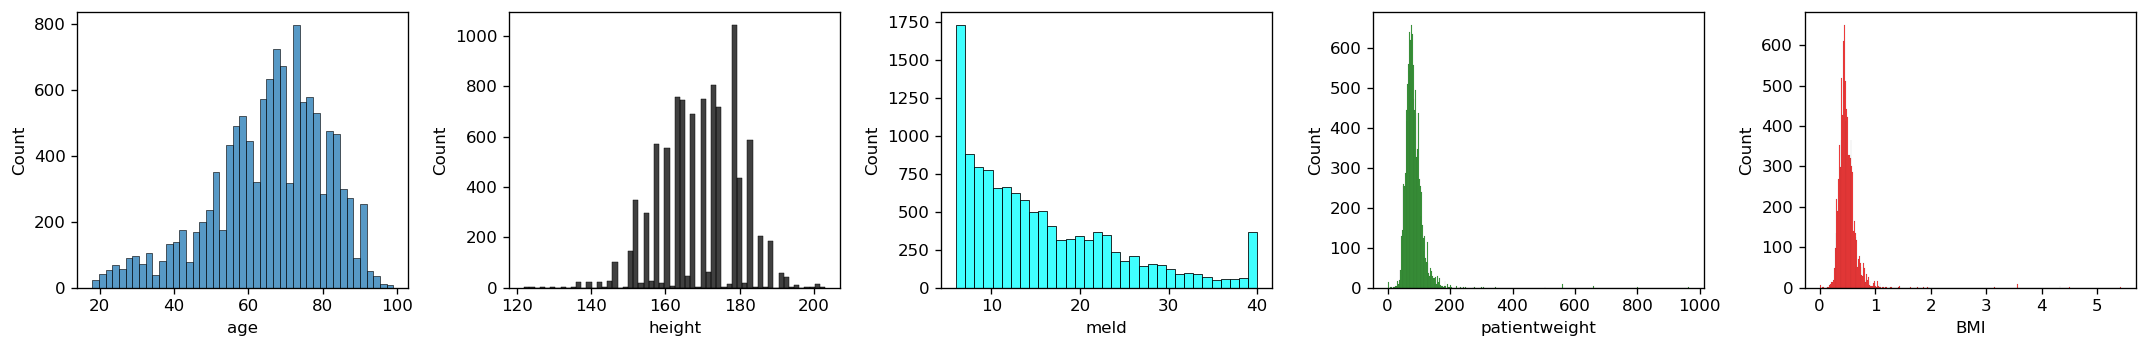

In [84]:
fig, axes = plt.subplots(1, 5, figsize=(18, 3), dpi=120)

sns.histplot(data=patient_data, x='age', ax=axes[0])
sns.histplot(data=patient_data, x='height', ax=axes[1], color='black')
sns.histplot(data=patient_data, x='meld', ax=axes[2], color='cyan')
sns.histplot(data=patient_data, x='patientweight', ax=axes[3], color='green')
sns.histplot(data=patient_data, x='BMI', ax=axes[4], color='red')
plt.tight_layout()
plt.savefig(figures_path / 'patient_attrs.png', dpi=120)
plt.show()

In [47]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import  RandomOverSampler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

In [319]:
X = patient_data.drop(['subject_id', 'avg_hr', 'avg_mbp', 'avg_rr', 'avg_temp', 'avg_spo2', 'avg_glucose'], axis=1)
y = patient_data[['avg_hr', 'avg_mbp', 'avg_rr', 'avg_spo2', 'avg_glucose']].apply(lambda x: get_event(x.avg_hr, x.avg_mbp, x.avg_rr, x.avg_spo2, x.avg_glucose), axis=1)

In [320]:
under_sampler = RandomUnderSampler()
over_sampler = RandomOverSampler()
# X, y = over_sampler.fit_resample(X, y)

In [321]:
Counter(y)

Counter({0: 9333, 1: 2915})

In [325]:
class NaiveModel(object):
    
    def __init__(self):        
        self.thresholds = {
            'age': 70.0,
            'weight': 200.0,
            'meld': 20,
            'bmi': 0.75
        }
        
        self.indexes = {}
    
    def _update_threshold(self, attr):
        idx = self.indexes[attr]
        search_space = range(int(self.X.values[:, idx].min()), int(self.X.values[:, idx].max()))
        solutions = [accuracy_score(self.y, (self.X.values[:, idx] > i).astype(int)) for i in search_space]
        self.thresholds[attr] = search_space[np.argmax(solutions)]
        
    
    def fit(self, X, y):
        self.X = X.reset_index().dropna().set_index('stay_id')
        self.y = y.reset_index().loc[X.reset_index().dropna().index][0].values
        
        self.X, self.y = under_sampler.fit_resample(self.X, self.y)
        
        self.indexes['age'] = list(self.X.columns).index('age')
        self.indexes['weight'] = list(self.X.columns).index('patientweight')
        self.indexes['meld'] = list(self.X.columns).index('meld')
        self.indexes['bmi'] = list(self.X.columns).index('BMI')
        
        for attr in self.indexes:
            self._update_threshold(attr)
            
    def predict(self, X):
        age_pred = (X.values[:, self.indexes['age']] > self.thresholds['age']).astype(int)
        weight_pred = (X.values[:, self.indexes['weight']] > self.thresholds['weight']).astype(int)
        meld_pred = (X.values[:, self.indexes['meld']] > self.thresholds['meld']).astype(int)
        bmi_pred = (X.values[:, self.indexes['bmi']] > self.thresholds['bmi']).astype(int)
        
        return np.array([1 if i > 1 else 0 for i in sum([age_pred, weight_pred, meld_pred, bmi_pred])])

In [326]:
model = NaiveModel()
model.fit(X, y)

In [327]:
model.thresholds

{'age': 96, 'weight': 560, 'meld': 39, 'bmi': 4}

In [163]:
accuracy_score(y, model.predict(X[:])), f1_score(y, model.predict(X[:])), precision_score(y, model.predict(X[:])), recall_score(y, model.predict(X[:])), roc_auc_score(y, model.predict(X[:]))

(0.7623285434356629,
 0.0034234851078397805,
 0.8333333333333334,
 0.0017152658662092624,
 0.5008040595911994)

In [47]:
%%time

params = {
    'n_estimators': 620,
    'max_depth': 11,
    'learning_rate': 0.05569188794654985,
    'subsample': 0.6366697161609715,
    'alpha': 0.002486088269178353,
    'lambda': 3.447337113123455e-07,
    'gamma': 2.8794846873373558e-05,
    'n_jobs' : 10
}


X_ = source2.drop(['subject_id', 'avg_hr', 'avg_sbp', 'avg_dbp', 'avg_mbp', 'avg_rr', 'avg_temp', 'avg_spo2', 'avg_glucose'], axis=1)
y_ = source2[['avg_hr', 'avg_mbp', 'avg_rr', 'avg_spo2', 'avg_glucose']].apply(lambda x: get_event(x.avg_hr, x.avg_mbp, x.avg_rr, x.avg_spo2, x.avg_glucose), axis=1)

for X, y in [(X_, y_), over_sampler.fit_resample(X_, y_), under_sampler.fit_resample(X_, y_)]:

    model = XGBClassifier(**params)
    cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=1)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=4, verbose=0)
    print('Mean ROC AUC: %.5f' % np.mean(scores))
    scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=4, verbose=0)
    print('Mean F1: %.5f' % np.mean(scores))
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=4, verbose=0)
    print('Mean Accuracy: %.5f' % np.mean(scores))
    scores = cross_val_score(model, X, y, scoring='precision', cv=cv, n_jobs=4, verbose=0)
    print('Mean Precision: %.5f' % np.mean(scores))
    scores = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=4, verbose=0)
    print('Mean Recall: %.5f' % np.mean(scores))
    
    print('')

Mean ROC AUC: 0.83236
Mean F1: 0.62403
Mean Accuracy: 0.84504
Mean Precision: 0.73889
Mean Recall: 0.54031

Mean ROC AUC: 0.97745
Mean F1: 0.92831
Mean Accuracy: 0.92602
Mean Precision: 0.90050
Mean Recall: 0.95789

Mean ROC AUC: 0.82832
Mean F1: 0.72340
Mean Accuracy: 0.72607
Mean Precision: 0.73045
Mean Recall: 0.71663

CPU times: user 832 ms, sys: 160 ms, total: 992 ms
Wall time: 52min 15s


In [194]:
def objective(trial, X, y, random_state=22, n_splits=3, n_repeats=2, n_jobs=1, early_stopping_rounds=50):

    params = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.9),
#         "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.6),
#         "subsample": trial.suggest_loguniform("subsample", 0.4, 0.8),
        "alpha": trial.suggest_loguniform("alpha", 1e-8, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 10.0),
#         "min_child_weight": trial.suggest_loguniform("min_child_weight", 1, 100),
        "seed": random_state, 'n_jobs': 10}

    model = XGBClassifier(**params)
    cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=1)
    scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=6, verbose=0)
    
    return np.mean(scores)

In [195]:
X_ = patient_data.drop(['subject_id', 'avg_hr', 'avg_mbp', 'avg_rr', 'avg_temp', 'avg_spo2', 'avg_glucose'], axis=1)
y_ = patient_data[['avg_hr', 'avg_mbp', 'avg_rr', 'avg_spo2', 'avg_glucose']].apply(lambda x: get_event(x.avg_hr, x.avg_mbp, x.avg_rr, x.avg_spo2, x.avg_glucose), axis=1)
X, y = under_sampler.fit_resample(X_, y_)

sampler = TPESampler(seed = 42)
study = create_study(direction="maximize", sampler=sampler)
study.optimize(lambda trial: objective(trial, X, y), n_trials = 30)

[I 2021-11-12 13:04:05,967] A new study created in memory with name: no-name-d119204d-b015-4b2f-8493-0046bfcfc037
[I 2021-11-12 13:05:08,321] Trial 0 finished with value: 0.7251600127831357 and parameters: {'n_estimators': 362, 'max_depth': 12, 'learning_rate': 0.2237771895633284, 'alpha': 0.0024430162614261413, 'lambda': 2.5361081166471375e-07, 'gamma': 2.5348407664333426e-07}. Best is trial 0 with value: 0.7251600127831357.
[I 2021-11-12 13:05:12,952] Trial 1 finished with value: 0.7063788616118206 and parameters: {'n_estimators': 140, 'max_depth': 11, 'learning_rate': 0.11340916757498269, 'alpha': 0.023585940584142682, 'lambda': 1.5320059381854043e-08, 'gamma': 5.360294728728285}. Best is trial 0 with value: 0.7251600127831357.
[I 2021-11-12 13:06:05,857] Trial 2 finished with value: 0.6906987074526783 and parameters: {'n_estimators': 683, 'max_depth': 5, 'learning_rate': 0.012853898127389312, 'alpha': 4.4734294104626844e-07, 'lambda': 5.472429642032198e-06, 'gamma': 0.0005282115394

In [280]:
config['xgboost_params'] = study.best_params

with open('../config.json', 'w') as f:
    f.write(json.dumps(config))

In [203]:
study.best_params

{'n_estimators': 256,
 'max_depth': 9,
 'learning_rate': 0.14926632143568677,
 'alpha': 1.0917968695823101,
 'lambda': 4.340290398807051e-05,
 'gamma': 3.7918895939722e-05}

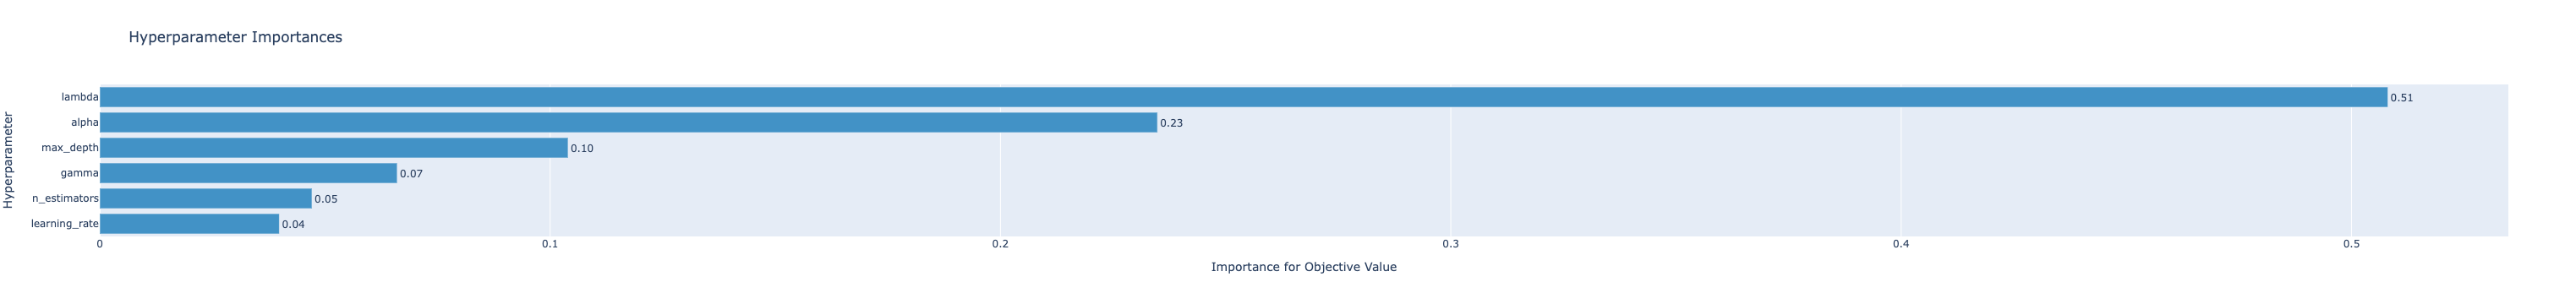

In [204]:
optuna.visualization.plot_param_importances(study)

In [205]:
import shap

In [336]:
X_ = patient_data.drop(['subject_id', 'avg_hr', 'avg_mbp', 'avg_rr', 'avg_temp', 'avg_spo2', 'avg_glucose'], axis=1)
y_ = patient_data[['avg_hr', 'avg_mbp', 'avg_rr', 'avg_spo2', 'avg_glucose']].apply(lambda x: get_event(x.avg_hr, x.avg_mbp, x.avg_rr, x.avg_spo2, x.avg_glucose), axis=1)
X, y = under_sampler.fit_resample(X_, y_)

model = XGBClassifier(**study.best_params, use_label_encoder=False, eval_metric='logloss')
model.fit(X, y)

XGBClassifier(alpha=1.0917968695823101, base_score=0.5, booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              eval_metric='logloss', gamma=3.7918895939722e-05, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              lambda=4.340290398807051e-05, learning_rate=0.14926632143568677,
              max_delta_step=0, max_depth=9, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=256, n_jobs=16,
              num_parallel_tree=1, random_state=0, reg_alpha=1.09179688,
              reg_lambda=4.34029062e-05, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [337]:
X.shape, y.shape, Counter(y)

((5830, 107), (5830,), Counter({0: 2915, 1: 2915}))

In [338]:
idx = 5825

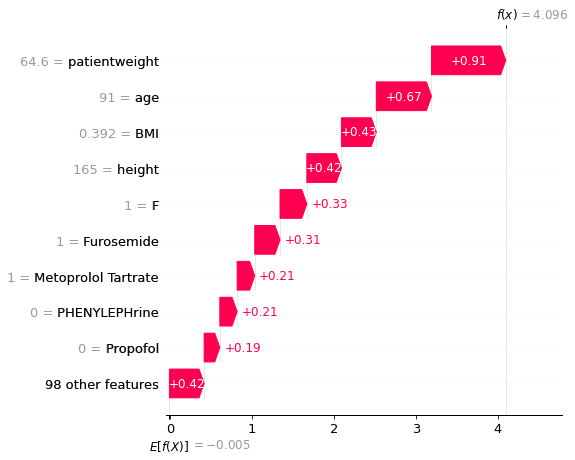

In [347]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[idx], show=False)
plt.tight_layout()
# plt.savefig(figures_path / 'feature_importance.png', dpi=120)
plt.show()

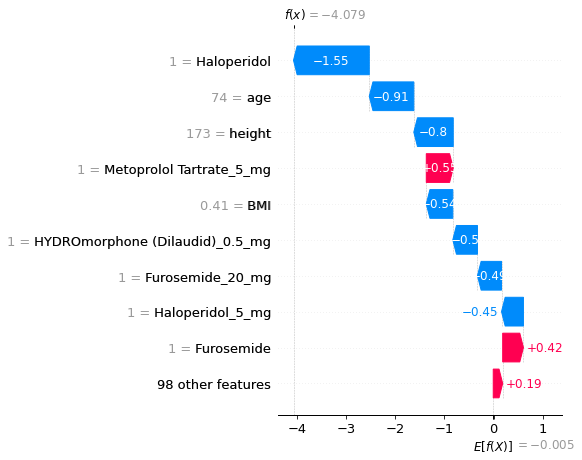

In [352]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[8], show=False)
plt.tight_layout()
plt.savefig(figures_path / 'feature_importance_normal.png', dpi=120)
plt.show()

In [348]:
shap.plots.force(shap_values[idx])

In [341]:
predictions = model.predict(X)

In [342]:
shap_values.shape, X.shape, Counter(y)

((5830, 107), (5830, 107), Counter({0: 2915, 1: 2915}))

Note that by default SHAP explains XGBoost classifer models in terms of their margin output, before the logistic link function. That means the units on the x-axis are log-odds units, so negative values imply probabilies of less than 0.5

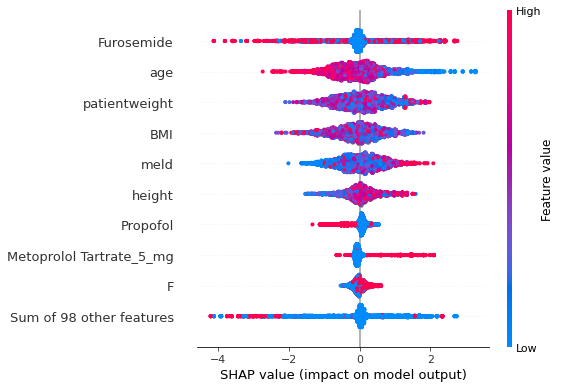

In [344]:
shap.plots.beeswarm(shap_values, show=False)
plt.tight_layout()
plt.savefig(figures_path / 'feature_importance2.png', dpi=120)
plt.show()

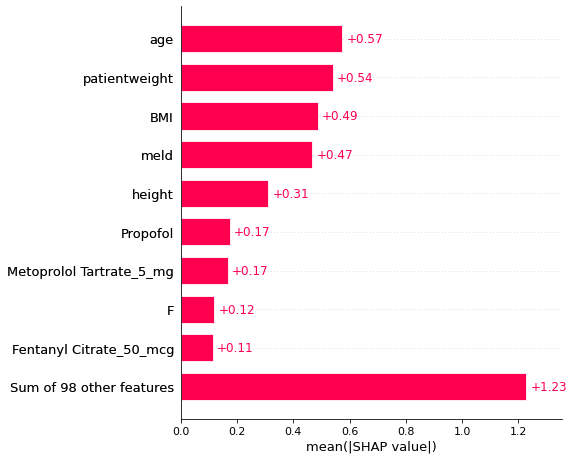

In [361]:
shap.plots.bar(shap_values, show=False)
plt.tight_layout()
plt.savefig(figures_path / 'feature_importance3.png', dpi=120)
plt.show()

In [359]:
import random


[4769, 4277, 3484, 520, 2377, 4907, 4846, 3030, 895, 96]

/ihome/hosmanbeyoglu/kor11/.local/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning:

ntree_limit is deprecated, use `iteration_range` or model slicing instead.



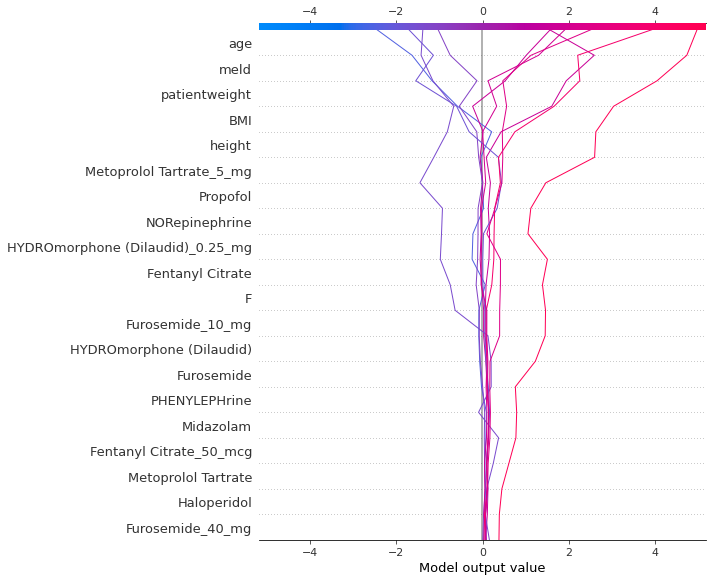

In [360]:
select = [random.randint(1, len(X)) for i in range(10)]
features = X.iloc[select]
features_display = X.loc[features.index]

shap.plots.decision(explainer.expected_value, explainer.shap_values(features), features_display)
plt.show()